In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sk
from   sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns


In [22]:

from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)


In [23]:
# load data from csv
df = pd.read_csv("data_HW3.csv", sep=",", header=0)

In [24]:
# Set the random state based on the sum of the last two digits of your IDs
random_state = sum([51, 17])  # Replace [1, 2, 3] with your actual IDs

train_data, test_data = sk.train_test_split(df, test_size=0.2, train_size=0.8, random_state=random_state)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def prepare_data(training_data, new_data):

    # Set the random state based on the sum of the last two digits of your IDs
    random_state = sum([51, 17])  # Replace [1, 2, 3] with your actual IDs

    # Split the data into training set and test set
    train_set, _ = train_test_split(training_data, test_size=0.2, random_state=random_state)

    # Define the what features to drop and what features to scale
    features_to_drop = ["current_location", "symptoms", "blood_type", "pcr_date"]
    featurs_to_min_max_scale = ["patient_id", "age",  "PCR_01", "PCR_02", "PCR_03", "PCR_05", "PCR_06"]
    featurs_to_standard_scale = ["weight", "num_of_siblings", "happiness_score", "household_income", "conversations_per_day", "sugar_levels", "sport_activity", "PCR_04","PCR_07", "PCR_08", "PCR_09", "PCR_10"]
    
    return_data = new_data.copy()

    # convert the blood type to numerical
    train_set['SpecialProperty'] = train_set['blood_type'].isin(['O+', 'B+']) * 2 - 1
    return_data['SpecialProperty'] = return_data['blood_type'].isin(['O+', 'B+']) * 2 - 1
    
    # convert the symptoms tocolumns
    symptoms_set = set(train_set['symptoms'].str.split(';').explode()) - {np.nan}
    for symptom in symptoms_set:
        train_set[symptom] = train_set['symptoms'].str.contains(symptom, regex=False)
    train_set["No Symptoms"] = train_set["symptoms"].isna()
    train_set = train_set.fillna(False)
    symptoms_set = list(symptoms_set) + ["No Symptoms"]
    for symptom in symptoms_set:
        train_set[symptom] = train_set[symptom] * 2 - 1

    # convert the symptoms tocolumns
    for symptom in symptoms_set:
        return_data[symptom] = return_data['symptoms'].str.contains(symptom, regex=False)
    return_data["No Symptoms"] = return_data["symptoms"].isna()
    return_data = return_data.fillna(False)
    symptoms_set = list(symptoms_set) + ["No Symptoms"]
    for symptom in symptoms_set:
        return_data[symptom] = return_data[symptom] * 2 - 1

    # convert the sex feature to numerical
    train_set['sex'] = train_set['sex'].map({'M': 1, 'F': -1})
    return_data['sex'] = return_data['sex'].map({'M': 1, 'F': -1})

    # Drop the features that are not relevant
    for feature in features_to_drop:
        train_set.drop(feature, axis=1, inplace=True)
        return_data.drop(feature, axis=1, inplace=True)

    # Scale the features
    standart_scaler = StandardScaler()
    standart_scaler.fit(train_set[featurs_to_standard_scale])
    return_data[featurs_to_standard_scale] = standart_scaler.transform(return_data[featurs_to_standard_scale])

    minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
    minmax_scaler.fit(train_set[featurs_to_min_max_scale])
    return_data[featurs_to_min_max_scale] = minmax_scaler.transform(return_data[featurs_to_min_max_scale])
    return return_data

In [26]:
normalized_data = prepare_data(train_data,df)
normalized_train_data, normalized_test_data = train_test_split(normalized_data,train_size=0.8, random_state=random_state)

In [27]:
sec1_train, sec1_test = train_test_split(normalized_train_data, test_size=0.2, random_state=random_state)

In [28]:




from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np


class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5, delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.delta = delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y, huber_delta: float):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        # Calculate predictions
        y_pred = np.dot(X, w) + b

        # Compute residuals
        residuals = y_pred - y

        # Compute Huber loss
        huber_residuals = np.abs(residuals)
        quadratic_loss = 0.5 * huber_residuals**2
        linear_loss = huber_delta * (huber_residuals - 0.5 * huber_delta)
        loss = np.where(huber_residuals <= huber_delta, quadratic_loss, linear_loss)

        # Return average loss
        return np.mean(loss)



    @staticmethod
    def gradient(w, b: float, X, y, huber_delta: float):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        y_pred = np.dot(X, w) + b

        # Compute residuals
        residuals = y_pred - y

        # Compute Huber loss derivatives
        huber_residuals = np.abs(residuals)
        derivative_quadratic = np.where(huber_residuals <= huber_delta, residuals, np.sign(residuals) * huber_delta)


        # Compute gradients
        g_w = np.dot(X.T, derivative_quadratic)/ len(y)

        g_b = np.mean(derivative_quadratic)

        return g_w, g_b



    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y, self.delta))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.delta))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y,self.delta)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            self.w = np.subtract(self.w, self.lr * g_w)
            self.b = self.b - (self.lr * g_b)

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y, self.delta))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.delta))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        y_pred = np.dot(X, self.w) + self.b

        return y_pred# from sklearn.base import BaseEstimator, RegressorMixin

# class LinearRegressor(BaseEstimator, RegressorMixin):
#     """
#     Custom linear regression model
#     """
#     def __init__(self, lr: float = 1e-5, huber_delta: float = 1.0):
#         """
#         Initialize an instance of this class.
#         ** Do not edit this method **

#         :param lr: the SGD learning rate (step size)
#         """
#         self.lr = lr
#         self.batch_size = 32
#         self.w = None
#         self.b = 0.0
#         self.delta = huber_delta

#     # Initialize a random weight vector
#     def init_solution(self, n_features: int):
#         """
#         Randomize an initial solution (weight vector)
#         ** Do not edit this method **

#         :param n_features:
#         """
#         self.w = np.zeros(n_features)
#         self.b = 0.0

#     @staticmethod
#     def loss(w, b: float, X, y, huber_delta: float):
#         """
#         Compute the MSE objective loss.

#         :param w: weight vector for linear regression; array of shape (n_features,)
#         :param b: bias scalar for linear regression
#         :param X: samples for loss computation; array of shape (n_samples, n_features)
#         :param y: targets for loss computation; array of shape (n_samples,)
#         :return: the linear regression objective loss (float scalar)
#         """
#         y_hat = np.dot(X, w) + b

#         residuals_sqrt = np.abs(y_hat - y)

#         squared_loss = 0.5 * residuals_sqrt**2
#         linear_loss = huber_delta * (residuals_sqrt - 0.5 * huber_delta)
#         loss = np.where(residuals_sqrt <= huber_delta, squared_loss, linear_loss)
#         return np.mean(loss)

#     @staticmethod
#     def gradient(w, b: float, X, y, huber_delta: float):
#         """
#         Compute the (analytical) linear regression objective gradient.

#         :param w: weight vector for linear regression; array of shape (n_features,)
#         :param b: bias scalar for linear regression
#         :param X: samples for loss computation; array of shape (n_samples, n_features)
#         :param y: targets for loss computation; array of shape (n_samples,)
#         :return: a tuple with (the gradient of the weights, the gradient of the bias)
#         """
#         y_hat = np.dot(X, w) + b
#         diff = y_hat - y
#         abs_residuals = np.abs(diff)
#         derivative_squared = np.where(abs_residuals <= huber_delta, diff, np.sign(diff) * huber_delta)
#         g_w = np.dot(X.T, derivative_squared)/ len(y)
#         g_b = np.mean(derivative_squared)
#         return g_w, g_b

#     def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
#                       X_val  =None, y_val = None):
#         """
#         Fit the model according to the given training data.

#         :param X: training samples; array of shape (n_samples, n_features)
#         :param y: training targets; array of shape (n_samples,)
#         :param max_iter: number of SGD iterations
#         :param keep_losses: should compute the train & val losses during training?
#         :param X_val: validation samples to compute the loss for (for logs only)
#         :param y_val: validation labels to compute the loss for (for logs only)
#         :return: training and validation losses during training
#         """
#         # Initialize learned parameters
#         self.init_solution(X.shape[1])

#         train_losses = []
#         val_losses = []

#         if keep_losses:
#             train_losses.append(self.loss(self.w, self.b, X, y, self.delta))
#             val_losses.append(self.loss(self.w, self.b, X_val, y_val, self.delta))

#         # Iterate over batches (SGD)
#         for itr in range(0, max_iter):
#             start_idx = (itr * self.batch_size) % X.shape[0]
#             end_idx = min(X.shape[0], start_idx + self.batch_size)
#             batch_X = X[start_idx: end_idx]
#             batch_y = y[start_idx: end_idx]

#             # TODO: Compute the gradient for the current *batch*
#             g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y,self.delta)

#             # Perform a gradient step
#             # TODO: update the learned parameters correctly
#             self.w = np.subtract(self.w, self.lr * g_w)
#             self.b = self.b - (self.lr * g_b)

#             if keep_losses:
#                 train_losses.append(self.loss(self.w, self.b,  X, y, self.delta))
#                 val_losses.append(self.loss(self.w, self.b,  X_val, y_val, self.delta))

#         return train_losses, val_losses

#     def fit(self, X, y, max_iter: int = 1000):
#         """
#         Fit the model according to the given training data.
#         ** Do not edit this method **

#         :param X: training samples; array of shape (n_samples, n_features)
#         :param y: training targets; array of shape (n_samples,)
#         :param max_iter: number of SGD iterations
#         """
#         self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

#         return self

#     def predict(self, X):
#         """
#         Regress labels on samples in X.

#         :param X: samples for prediction; array of shape (n_samples, n_features)
#         :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
#         """
#         y_pred = np.dot(X, self.w) + self.b
#         return y_pred
    


In [29]:
def numerical_subgradient(w, b, X, y, huber_delta: float, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y, huber_delta)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y, huber_delta) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, huber_delta: float, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y, huber_delta)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, huber_delta, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()




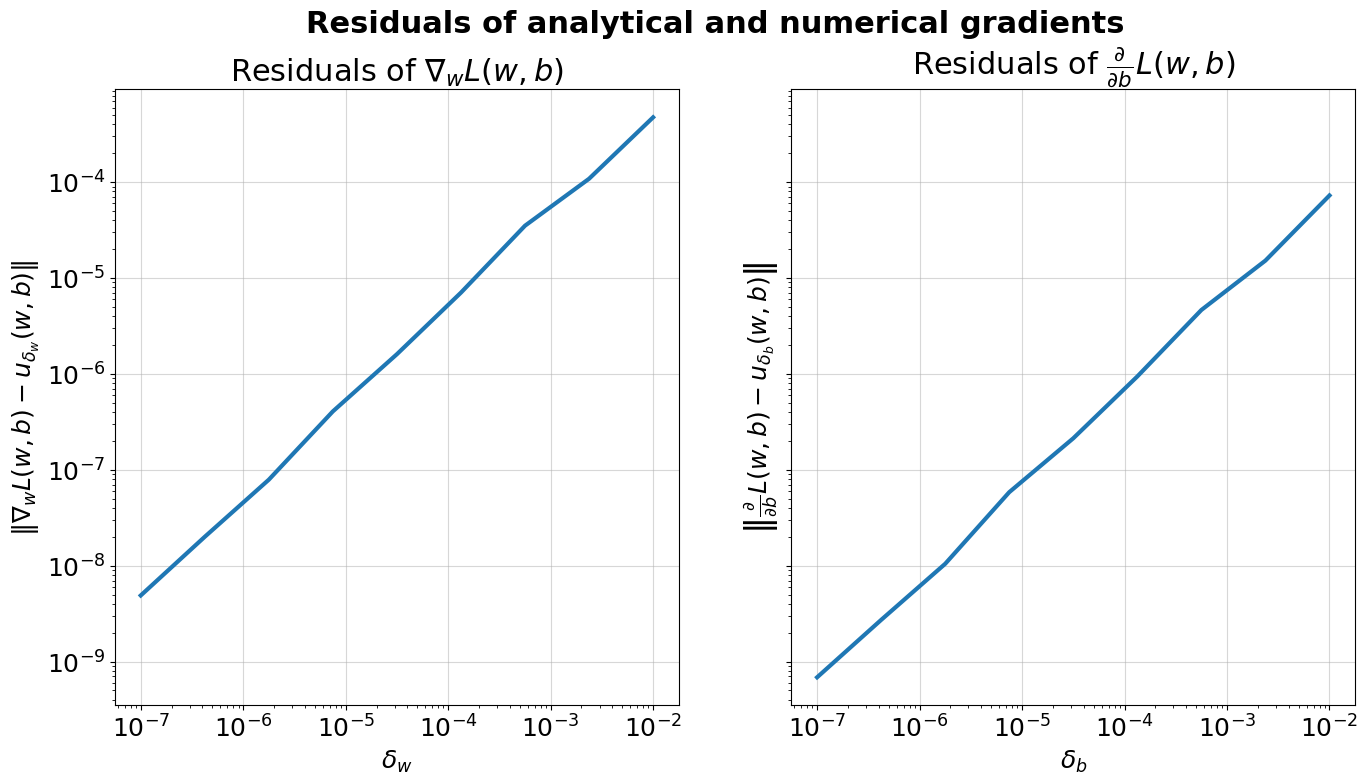

In [30]:
X_train = pd.DataFrame.copy(normalized_train_data)
y_train = X_train['contamination_level']
X_train.drop('contamination_level', axis=1, inplace=True)
huber_delta = 0.1
compare_gradients(X_train, y_train, huber_delta, deltas=np.logspace(-7, -2, 9))

In [31]:
def test_lr(X_train, y_train, X_val, y_val, huber_delta: float, title: str, max_iter: int = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr, huber_delta)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter=max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = ' + str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

In [32]:
def get_p(y_true, y_hat):
    # Assuming y_true and y_pred are defined
    residuals = np.abs(y_true - y_hat)

    # Compute the quartiles and IQR
    Q1 = np.percentile(residuals, 25)
    Q3 = np.percentile(residuals, 75)
    IQR = Q3 - Q1

    # Identify outlier indices
    outlier_indices = np.where((residuals < (Q1 - 1.5 * IQR)) | (residuals > (Q3 + 1.5 * IQR)))[0]
    outlier_percentage = len(outlier_indices) / len(residuals) 

    return outlier_percentage


In [33]:
from sklearn.linear_model import LinearRegression
X_train = pd.DataFrame.copy(sec1_train)
y_train = X_train['contamination_level']
X_train.drop('contamination_level', axis=1, inplace=True)
X_test = pd.DataFrame.copy(sec1_test)
y_test = X_test['contamination_level']
X_test.drop('contamination_level', axis=1, inplace=True)

def good_delta(X,Y):
    regressor = LinearRegression()
    regressor.fit(X, Y)
    y_hat = regressor.predict(X)
    residuals = np.abs(Y - y_hat)
    residuals_list = residuals.values.tolist()
    residuals_list.sort()
    n = len(y_train)

    believed_p = (get_p(y_train, y_hat))

    percentile_index = int((1-believed_p) * n)  
    delta = residuals[percentile_index]
    return delta

huber_delta = good_delta(X_train, y_train)

lr size = 1e-09, Best train loss = 1.6771657786101986, Best validation loss = 1.767528896973043
lr size = 1e-08, Best train loss = 1.6771423619375314, Best validation loss = 1.7675027311848763
lr size = 1e-07, Best train loss = 1.676908317729679, Best validation loss = 1.7672412071721055
lr size = 1e-06, Best train loss = 1.6745800711351542, Best validation loss = 1.7646393176183375
lr size = 1e-05, Best train loss = 1.652463938263179, Best validation loss = 1.7399073422849756
lr size = 0.0001, Best train loss = 1.510480538555902, Best validation loss = 1.5820683806718803
lr size = 0.001, Best train loss = 1.256712745058819, Best validation loss = 1.3506372149184223
lr size = 0.01, Best train loss = 1.2112461679081366, Best validation loss = 1.3324832070680237
lr size = 0.1, Best train loss = 1.2102420622236552, Best validation loss = 1.3288274584282695


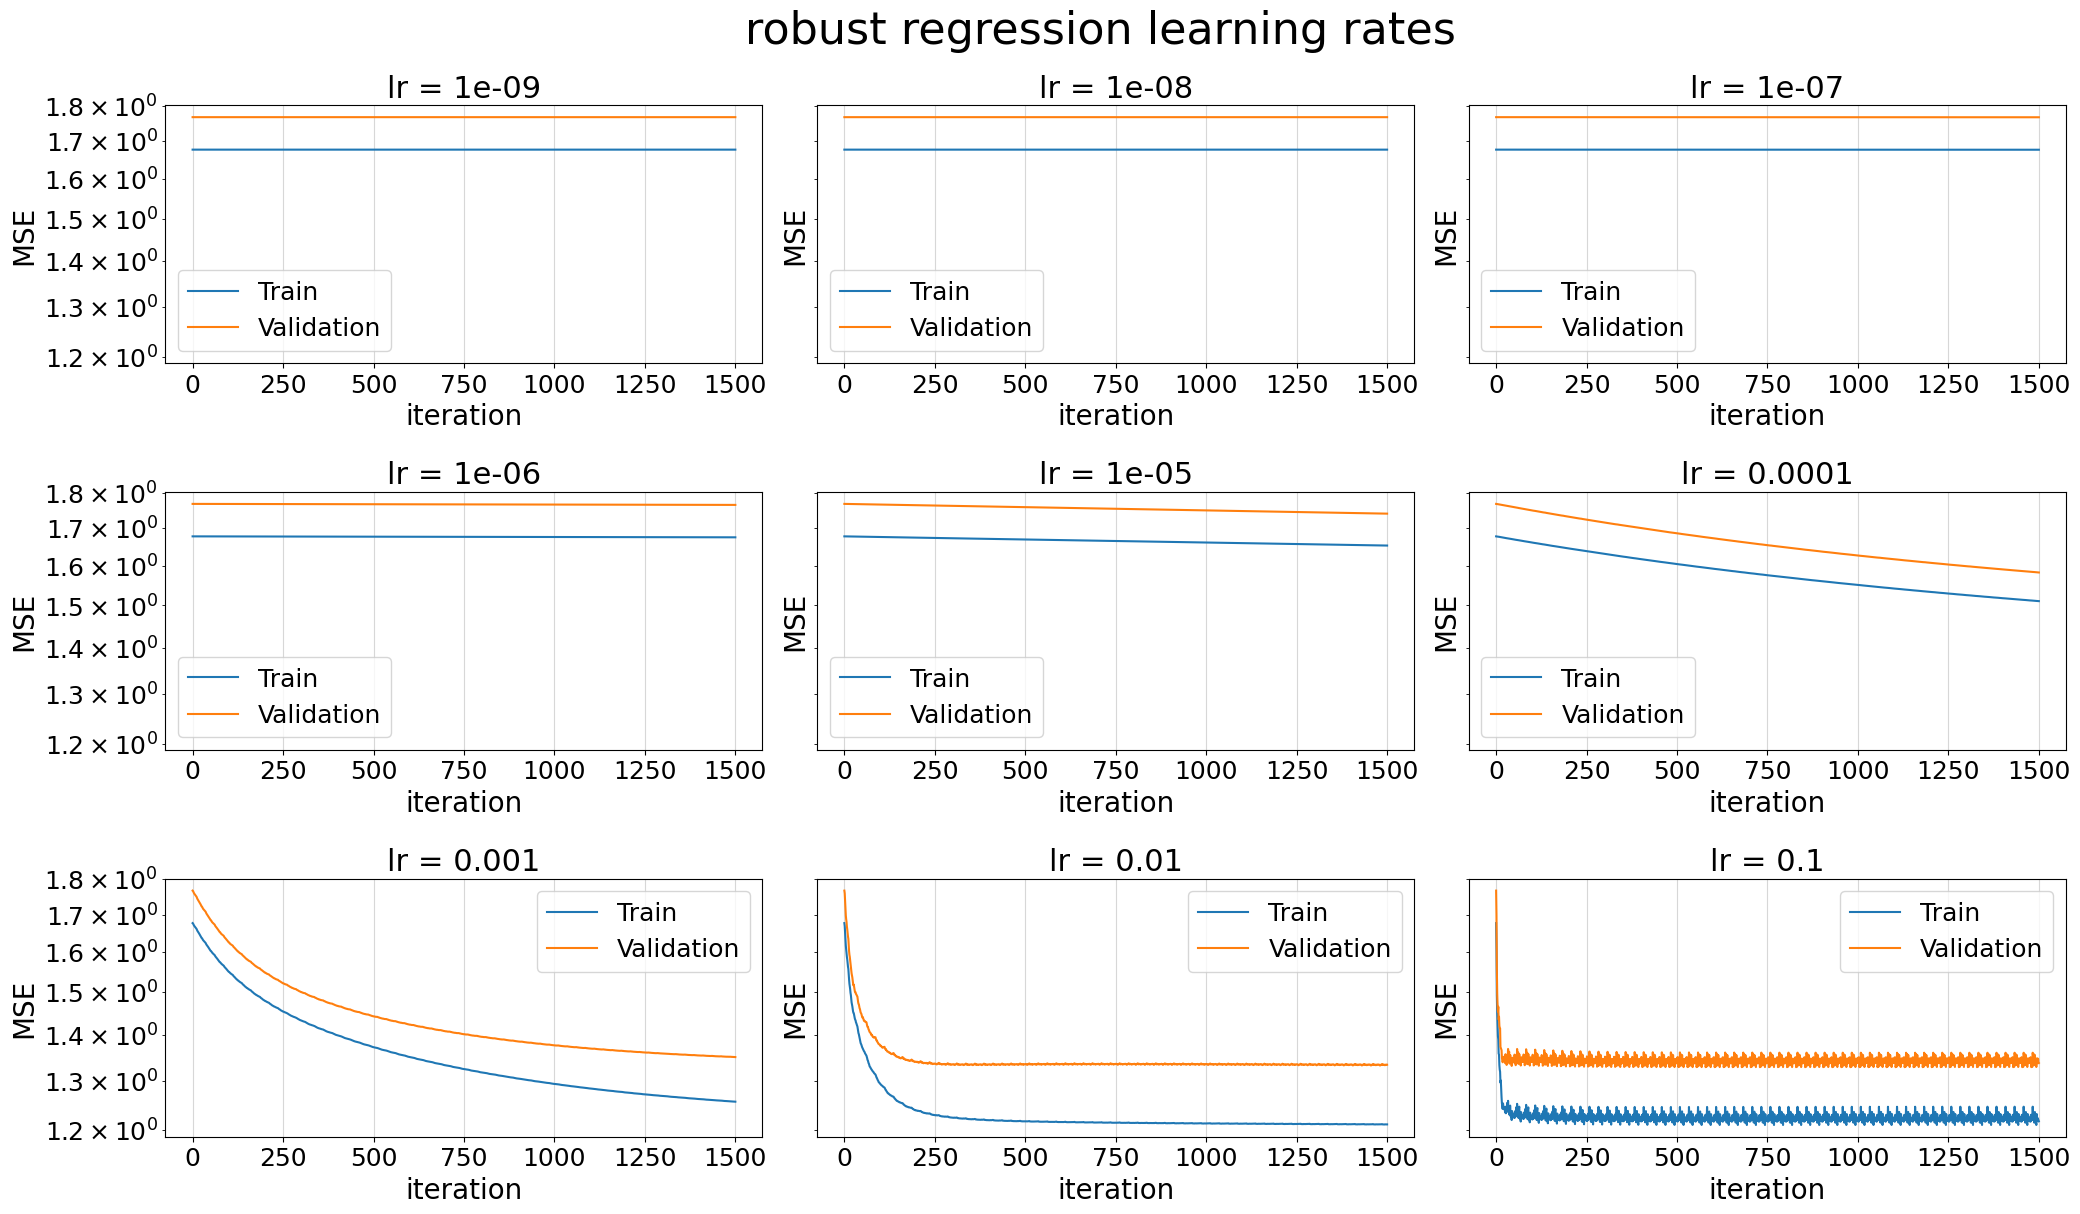

In [34]:
test_lr(X_train, y_train, X_test, y_test, huber_delta,'robust regression learning rates')

In [35]:
from sklearn.model_selection import cross_val_score ,cross_validate

from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer , mean_squared_error
X_train = pd.DataFrame.copy(normalized_train_data)
y_train = X_train['contamination_level']
X_train.drop('contamination_level', axis=1, inplace=True)

# Create a DummyRegressor
dummy_regressor = DummyRegressor(strategy="mean")

def huber_loss(y_true, y_pred, delta=huber_delta):
    diff = np.abs(y_true - y_pred)
    loss = np.where(diff <= delta, 0.5 * diff**2, delta * (diff - 0.5 * delta))
    return np.mean(loss)

huber_loss_scorer = make_scorer(huber_loss , greater_is_better = False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

def crossvalidationhuber(reg ,Atrain_x , Atrain_y ):

    cv_scores = cross_validate(reg, Atrain_x, Atrain_y, cv=5, scoring={'huber_loss':huber_loss_scorer ,'mse_scorer':mse_scorer },return_train_score = True)
    train_huber_loss = np.mean(-cv_scores['train_huber_loss'])
    validation_huber_loss = np.mean(-cv_scores['test_huber_loss'])
    mse_train_loss = np.mean(-cv_scores['train_mse_scorer'])
    mse_validation_loss = np.mean(-cv_scores['test_mse_scorer'])
    return train_huber_loss ,validation_huber_loss ,mse_train_loss ,mse_validation_loss

train_huber_loss ,validation_huber_loss ,mse_train_loss ,mse_validation_loss = crossvalidationhuber(dummy_regressor , X_train ,y_train)



print("the train huber loss is",train_huber_loss )
print("the mse validation loss is",mse_validation_loss )

the train huber loss is 1.6216208323286019
the mse validation loss is 5.139737190083862


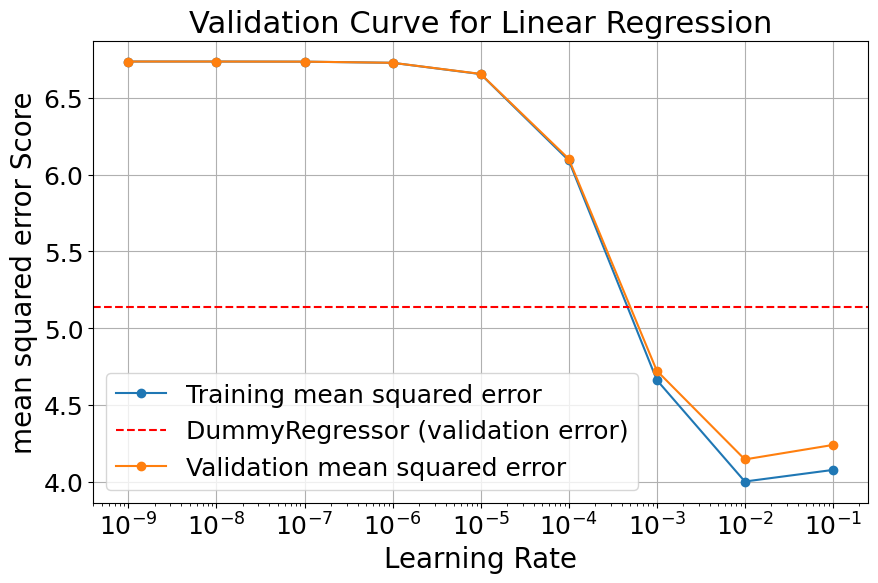

the best learning rate value is 0.01
the best validation value is 4.147086576771388


In [36]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate , cross_val_score


# Create a range of learning rate values
lr_list = np.logspace(-9, -1, 9)

# Initialize empty lists to store mean training and validation scores
train_scores_mean = []
test_scores_mean = []



for lr in lr_list:
    reg = LinearRegressor(lr=lr, delta=huber_delta)


    # Perform cross-validation and extract train and test scores
    cv_results = cross_validate(reg, X_train, y_train, cv=5, scoring =  'neg_mean_squared_error', return_train_score=True)

    # Calculate mean training and validation scores
    train_score_mean = np.mean(cv_results['train_score'])
    test_score_mean = np.mean(cv_results['test_score'])

    # Append mean scores to the lists
    train_scores_mean.append(np.absolute(train_score_mean))
    test_scores_mean.append(np.absolute(test_score_mean))

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(lr_list, train_scores_mean, label='Training mean squared error', marker='o')
#dummy regressor score
dummy_regressor = DummyRegressor(strategy="mean")
dummy_val_error = -cross_val_score(dummy_regressor ,X_train, y_train,cv=5, scoring= 'neg_mean_squared_error').mean()
plt.axhline( y = dummy_val_error , color = 'r',linestyle = '--',label = 'DummyRegressor (validation error)')
plt.semilogx(lr_list, test_scores_mean, label='Validation mean squared error', marker='o')
plt.title('Validation Curve for Linear Regression')
plt.xlabel('Learning Rate')
plt.ylabel('mean squared error Score')
plt.legend()
plt.grid(True)
plt.show()

optimal_validation_index  = np.argmin(test_scores_mean)
optimal_lr_value = lr_list[optimal_validation_index]
optimal_val_error = test_scores_mean[optimal_validation_index]

print("the best learning rate value is",optimal_lr_value )
print("the best validation value is",optimal_val_error )


In [37]:

reg = LinearRegressor(lr=optimal_lr_value, delta=huber_delta)
cv_scores = cross_validate(reg,X_train, y_train, cv=5, scoring={'huber_loss':huber_loss_scorer ,'mse_scorer':mse_scorer },return_train_score = True)
train_huber_loss = np.mean(-cv_scores['train_huber_loss'])
validation_huber_loss = np.mean(-cv_scores['test_huber_loss'])
mse_train_loss = np.mean(-cv_scores['train_mse_scorer'])
mse_validation_loss = np.mean(-cv_scores['test_mse_scorer'])


print("the train huber loss is",train_huber_loss )
print("the mse validation loss is",optimal_val_error )

the train huber loss is 1.2304338142562143
the mse validation loss is 4.147086576771388


In [38]:
reg_section_6 = LinearRegressor(lr=optimal_lr_value, delta=huber_delta)
reg_section_6.fit(X_train, y_train)

LinearRegressor(delta=1.740473033959183, lr=0.01)

best alpha value is 0.001 , its train accuracy is 3.8887750246939397and its validation accuracy is 4.079250030659958


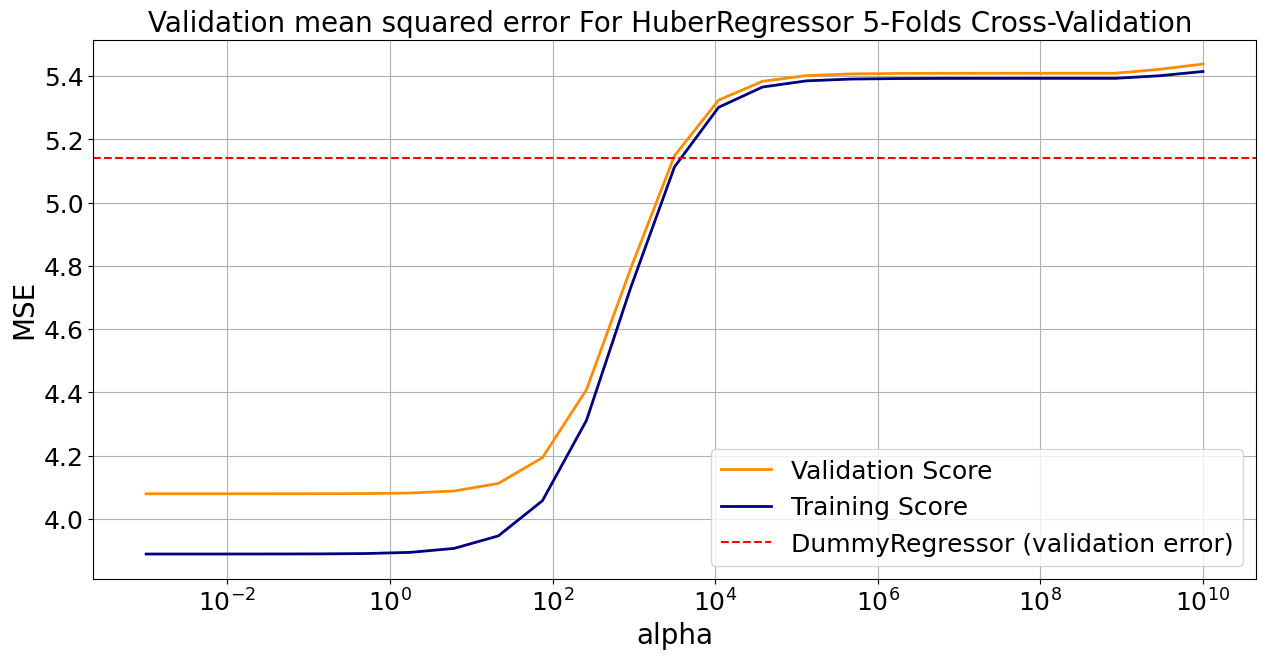

In [39]:
from sklearn.linear_model import HuberRegressor


alpha_list = np.logspace(-3, 10, 25)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []


for alpha in alpha_list:
  huber_reg = HuberRegressor(alpha = alpha ,epsilon = huber_delta, fit_intercept=True)
  cv = cross_validate(huber_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  dummy_error.append(dummy_val_error)


plt.figure(figsize=(15, 7))
plt.semilogx(alpha_list, validation_scores_mean, label="Validation Score", color="darkorange", lw=2)
plt.semilogx(alpha_list, train_scores_mean, label="Training Score", color="navy", lw=2)
plt.axhline( y = dummy_val_error , color = 'r',linestyle = '--',label = 'DummyRegressor (validation error)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Validation mean squared error For HuberRegressor 5-Folds Cross-Validation ", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_alpha_covid = alpha_list[best_validation_accuracy_index]
print("best alpha value is "+str(best_alpha_covid)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))



In [40]:
optimal_regularization = 0.001


reg_huber_regularization = HuberRegressor(alpha = optimal_regularization ,epsilon = huber_delta, fit_intercept=True)
cv_scores = cross_validate(reg_huber_regularization,X_train, y_train, cv=5, scoring={'huber_loss':huber_loss_scorer ,'mse_scorer':mse_scorer },return_train_score = True)
train_huber_loss = np.mean(-cv_scores['train_huber_loss'])
validation_huber_loss = np.mean(-cv_scores['test_huber_loss'])
mse_train_loss = np.mean(-cv_scores['train_mse_scorer'])
mse_validation_loss = np.mean(-cv_scores['test_mse_scorer'])


print("the train huber loss is",train_huber_loss )
print("the mse validation loss is",optimal_val_error )

the train huber loss is 1.2253453412757302
the mse validation loss is 4.147086576771388


In [41]:
reg_huber_regularization = HuberRegressor(alpha = optimal_regularization ,epsilon = huber_delta, fit_intercept=True)
reg_huber_regularization.fit(X_train, y_train)

HuberRegressor(alpha=0.001, epsilon=1.740473033959183)

Text(0, 0.5, 'absolute value')

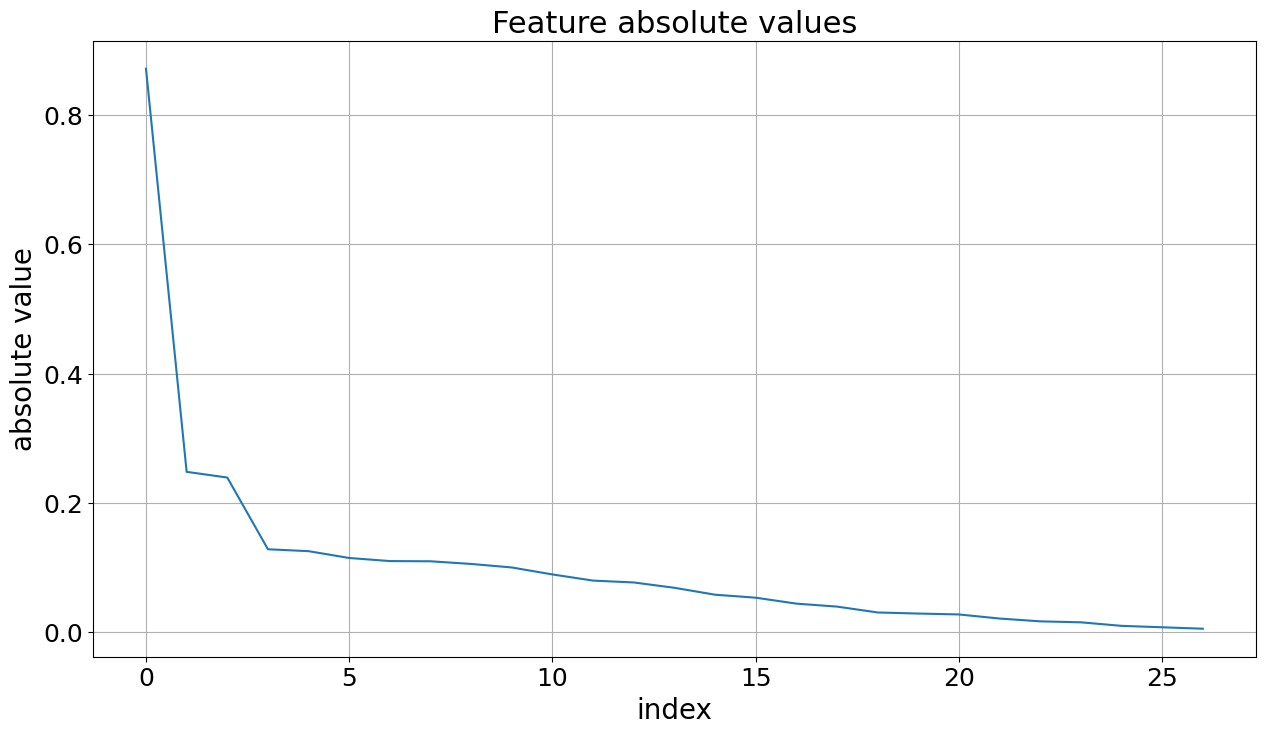

In [42]:
#Plotting absolute value of coefficients by descending order
sorted_coefs = list(np.sort(np.absolute(reg_huber_regularization.coef_))[::-1])

index = [i for i in range(reg_huber_regularization.coef_.size)]
plt.figure(figsize=(15, 8))
plt.plot(index, sorted_coefs)
plt.grid(visible = True)
plt.title("Feature absolute values")
plt.xlabel("index")
plt.ylabel("absolute value")



C:\Users\Yitzchak\AppData\Local\Temp\ipykernel_18896\4128755216.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


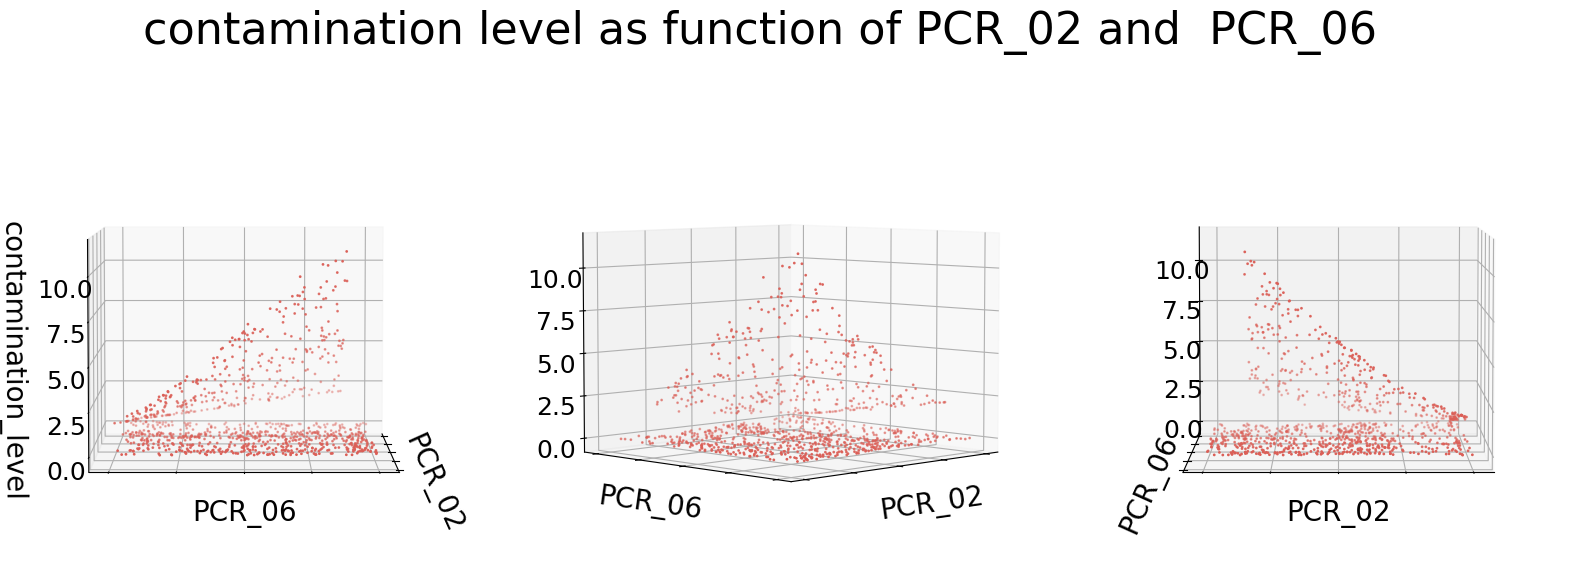

In [46]:
contamination_subset_train = normalized_train_data[['PCR_02','PCR_06','contamination_level']]


def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

plot3d(contamination_subset_train,'PCR_02','PCR_06','contamination_level','Contamination level as a function of PCR_02 and PCR_06')